In [197]:
!pip install catboost
import pandas as pd
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [198]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [199]:
df = pd.read_csv(r'drive/MyDrive/Skripsi/india.csv')

In [200]:
#Dropping unnecessary columns
cols_to_drop = ['Station_Code', 'Locations', 'State', 'Temp', 'Year']
df = df.drop(cols_to_drop, axis=1)
df.head()

,DO,pH,EC,BOD,Nitrate,FecalC,TotalC,Class
0,6.7,7.5,203.0,6.940049,0.1,11.0,27.0,4
1,5.7,7.2,189.0,2.000000,0.2,4953.0,8391.0,4
2,6.3,6.9,179.0,1.700000,0.1,3243.0,5330.0,4
3,5.8,6.9,64.0,3.800000,0.5,5382.0,8443.0,4
4,5.8,7.3,83.0,1.900000,0.4,3428.0,5500.0,4


In [201]:
#Seperating X & y
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [202]:
#Splitting test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [203]:
#Feature selection with Mutual Information
from sklearn.feature_selection import SelectKBest,mutual_info_classif
mic = SelectKBest(score_func=mutual_info_classif,k=4)
X_train = mic.fit_transform(X_train, y_train)

feature_idx = mic.get_support(indices=True)
feature_names = df.columns[feature_idx]

# creating selected features dataframe with corresponding column names
features = pd.DataFrame(X_train, columns=feature_names)

feature_MI_score = pd.Series(mic.scores_)
display(feature_MI_score)
display(mic.get_support())
display(features.head())

0    0.053823
1    0.144735
2    0.138666
3    0.084531
4    0.177086
5    0.439025
6    0.189636
dtype: float64

array([False,  True, False, False,  True,  True,  True])

,pH,Nitrate,FecalC,TotalC
0,7.3,0.60,68.0000,191.0000
1,7.4,14.85,3475.0000,12000.0000
2,8.1,0.71,1930.0000,4450.0000
3,7.8,11.00,362529.3647,533687.1657
4,7.9,0.24,735.0000,1510.0000


In [204]:
# importing modules
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_regression

# creating X - train and Y - test variables
#X = main_df.iloc[:,0:-1] 
#Y = main_df.iloc[:,-1]

# feature extraction
#test = SelectKBest(score_func=f_regression, k=5)
#features = test.fit_transform(X,Y)

# finding selected column names
#feature_idx = test.get_support(indices=True)
#feature_names = main_df.columns[feature_idx]

# creating selected features dataframe with corresponding column names
#features = pd.DataFrame(features, columns=feature_names)

#features.head()

In [205]:
#Applying data standardization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

In [206]:
#Apply SMOTE and create new X_train & y_train
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [207]:
#Empty result dataframe
res = pd.DataFrame(index=['precision','recall','f1-score','accuracy'])

In [208]:
from sklearn.metrics import zero_one_loss
#Result Function
def result(clf, Classifier_Name):
  #Model Fitting
  clf.fit(X_train, y_train)
  
  #Showing performance result
  X_test_mic = mic.transform(X_test)
  X_test_sc = sc.transform(X_test_mic)
  y_pred=clf.predict(X_test_sc)
  from sklearn.metrics import classification_report
  clf_res = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

  #Append classifier result to result DataFrame
  res[str(Classifier_Name)] = [clf_res['weighted avg']['precision'],
                               clf_res['weighted avg']['recall'], 
                               clf_res['weighted avg']['f1-score'], 
                               clf_res['accuracy']]
  display(res)

  #Creating confusion matrix illustration
  from sklearn.metrics import ConfusionMatrixDisplay
  disp = ConfusionMatrixDisplay.from_estimator(
    clf, X_test_sc, y_test, xticks_rotation="vertical", 
    display_labels=['Unsuitable', 'Very Poor', 'Poor', 'Good', 'Excellent'])
  disp.ax_.set_title("Confusion Matrix for " + str(Classifier_Name) + " Classifier")

,Decision Tree
precision,0.970893
recall,0.969900
f1-score,0.969671
accuracy,0.969900


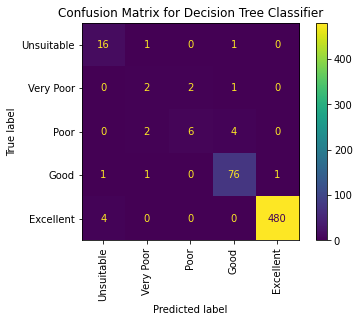

In [209]:
#Using Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
result(dt_clf, "Decision Tree")

,Decision Tree,Random Forest
precision,0.970893,0.973268
recall,0.969900,0.974916
f1-score,0.969671,0.973210
accuracy,0.969900,0.974916


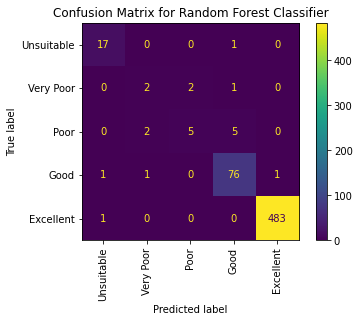

In [210]:
# Using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
result(rf_clf, "Random Forest")

,Decision Tree,Random Forest,SVM
precision,0.970893,0.973268,0.878318
recall,0.969900,0.974916,0.742475
f1-score,0.969671,0.973210,0.803175
accuracy,0.969900,0.974916,0.742475


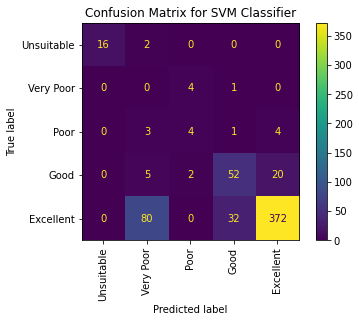

In [211]:
# Using Kernel SVM Classifier
from sklearn.svm import SVC
svm_clf = SVC(kernel = 'rbf', random_state = 0)
result(svm_clf, "SVM")

,Decision Tree,Random Forest,SVM,Naive Bayes
precision,0.970893,0.973268,0.878318,0.954078
recall,0.969900,0.974916,0.742475,0.933110
f1-score,0.969671,0.973210,0.803175,0.941828
accuracy,0.969900,0.974916,0.742475,0.933110


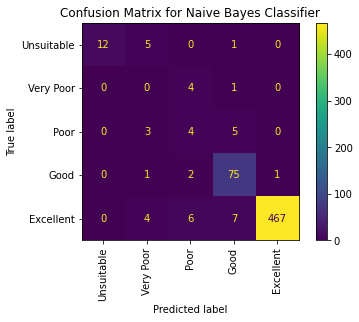

In [212]:
# Using Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
result(nb_clf, "Naive Bayes")

,Decision Tree,Random Forest,SVM,Naive Bayes,CatBoost
precision,0.970893,0.973268,0.878318,0.954078,0.975116
recall,0.969900,0.974916,0.742475,0.933110,0.976589
f1-score,0.969671,0.973210,0.803175,0.941828,0.975656
accuracy,0.969900,0.974916,0.742475,0.933110,0.976589


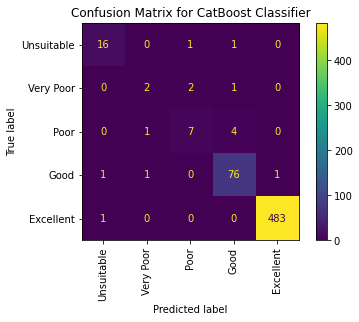

In [213]:
# Using CatBoost Classifier
from catboost import CatBoostClassifier
cb_clf = CatBoostClassifier(random_seed=42, logging_level='Silent')
result(cb_clf, "CatBoost")